In [ ]:
      
# https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
import re
!pip install cleantext
from cleantext import clean
import os
import random
import math
from nltk.tokenize import TweetTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize


In [ ]:
!apt install enchant
!pip install PyEnchant
import enchant

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Preprocess the data 

tweet_tokenizer = TweetTokenizer()
tokenizer = get_tokenizer('basic_english')

def replace_dates(text):
        date_format_a = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' <DATE> ', text)
        date_format_b = re.sub(
            r'[A-Za-z]{2,8}\s\d{1,2},?\s\d {4}', ' <DATE> ', date_format_a)
        date_format_c = re.sub(
            r'\d{2} [A-Z][a-z]{2,8} \d{4}', ' <DATE> ', date_format_b)
        return date_format_c

def replace_concurrent_punctuation(text):
    # replace concurrent punctuation with single punctuation
    return re.sub(r'(!|"|\#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|\/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|‘|\{|\||\}|~){2,}', r' ', text)

def replace_hash_tags(text):
        return re.sub(r'(\s|^)#(\w+)', ' <HASHTAG> ', text)

def remove_special_characters(text):
        # remove special characters other than punctuation
        return re.sub(r'[^A-Za-z0-9\s\.\,\!\?\'\"\:\;]', ' ', text)

def remove_extra_spaces(text):
        return re.sub(r'\s{2,}', ' ', text)

def replace_hyphenated_words(text):
        # replace hyphenated words with words seperated by space
        return re.sub(r'(\w+)-(\w+)', r'\1 \2', text)

def read_data(filename, n_lines):
    with open(filename, 'r') as f:
        lines = []
        for _ in range(n_lines):
            line = f.readline().strip()
            line = re.sub(r'<|>', ' ', line)
            line = replace_dates(line)
            line = replace_hyphenated_words(line)
            line = replace_hash_tags(line)
            # remove < and > from the text
            line = clean(line, no_emoji=True,
                         no_urls=True,
                         no_emails=True,
                         no_phone_numbers=True,
                         no_currency_symbols=True,           
                         replace_with_url=" <URL> ",
                         replace_with_email=" <EMAIL> ",
                         replace_with_phone_number=" <PHONE> ",
                         replace_with_currency_symbol=" <CURRENCY> ",
                         lower=True)
            line = remove_special_characters(line)
            #line = replace_concurrent_punctuation(line)
            line = clean(line,no_numbers=True,no_digits=True,no_punct=True, replace_with_number=" <NUMBER> ",replace_with_digit=" ",replace_with_punct="")
            line = "<BEGIN> " + line + " <END>"
            line = remove_extra_spaces(line)
            tokens=tokenizer(line)
            if len(tokens)>1:
                lines.append(tokens)
    return lines


def save_data(filename, lines):
    # Save the data to a file
    with open(filename, 'w')as f:
        for line in lines:
            line = ' '.join(line)
            f.write(line.strip()+'\n')




In [ ]:
# if not os.path.exists('./processed_data'):
#     os.mkdir('processed_data')

# data = read_data('data/alternate/L3Cube-HingCorpus_roman/R11_final_data/concatenated_train_final_shuffled.txt',20000)
# train,valid = train_test_split(data, test_size=0.3, random_state=42)
# valid,test=train_test_split(valid, test_size=0.5, random_state=42)
# #print(train[1:100])
# save_data('processed_data/train.txt', train)
# save_data('processed_data/valid.txt', valid)
# save_data('processed_data/test.txt', test)

In [ ]:
#---------------------------------------------------------------------

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:
class L3CubeDataset(Dataset):
    def __init__(self,filename,vocab=None,ngram=5):
        data = self.read_data(filename)
        if vocab is None:
            self.vocab, self.ind2vocab = self.build_vocab(data)
        else:
            self.vocab = vocab
            self.ind2vocab = {v:k for k,v in vocab.items()}
        self.n = ngram
        self.x,self.y,self.x_type,self.y_type = self.__create_dataset(data)
        
    def get_vocab(self):
        return self.vocab

    def read_data(self,filename):
        lines = []
        with open(filename, 'r') as f:
            for line in f.readlines():
                lines.append(line.strip().split(' '))
        return lines

    def build_vocab(self,data):
        word_set = set()
        for line in data:
            for word in line:
                if word not in word_set:
                    word_set.add(word)
        # sort the vocab
        word_list = sorted(list(word_set))
        vocab_dict = {"<unk>":0}
        for i,word in enumerate(word_list):
            vocab_dict[word]=i+1
        ind2word = {v:k for k,v in vocab_dict.items()}
        return vocab_dict, ind2word
    
    def get_ngram(self, tokens):
        n =self.n
        ngram = []
        if len(tokens) == 0:
            return None
        tokens = ["<begin>" for _ in range(n-2)] + tokens
        for i in range(len(tokens)-n+1):
            ngram.append(tokens[i:i+n])
        return ngram
    
    def __get_seq(self, tokens):
        vec= []
        for word in tokens:
            if word in self.vocab:
                vec.append(self.vocab[word])
            else:
                vec.append(self.vocab["<unk>"])
        return vec
    
    def __get_type(self, tokens):
        vec = []
        enc = enchant.Dict("en_IN")
        for w in tokens:
            if enc.check(w): 
                vec.append(1) #English
            else: 
                vec.append(0) #Hindi
        return vec
        
    def __create_dataset(self, data):
        x = []
        y= []
        x_type = []
        y_type = []
        ngrams = []
        for line in data:
            ngrams.extend(self.get_ngram(line))
        
        for ngram in ngrams:
            x_tokens = ngram[:-1]
            y_tokens = ngram[1:]
            x.append(self.__get_seq(x_tokens))
            y.append(self.__get_seq(y_tokens))
            x_type.append(self.__get_type(x_tokens))
            y_type.append(self.__get_type(y_tokens))
        return torch.LongTensor(x),torch.LongTensor(y),torch.LongTensor(x_type),torch.LongTensor(y_type)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.x_type[idx], self.y_type[idx]
    
    def get_dataloader(self, batch_size,shuffle=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle,drop_last=True)
    

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class LinceDataset(Dataset):
    def __init__(self, filename, vocab_english=None, vocab_hinglish=None, ngram=5):
        data_english, data_hinglish = self.read_data(filename)
        self.word_count ={}
        self.single_counts = 0
        for list_tokens in data_hinglish:
            for token in list_tokens:
                if token not in self.word_count:
                    self.word_count[token] = 0
                self.word_count[token] += 1
        
        for word in self.word_count:
            if self.word_count[word] == 1: 
                self.single_counts += 1

        if vocab_hinglish is None:
            self.vocab_h, self.ind2vocab_h = self.build_vocab(data_hinglish)
        else:
            self.vocab_h = vocab_hinglish
            self.ind2vocab_h = {v: k for k, v in vocab_hinglish.items()}
        self.n = ngram
        self.x, self.y, self.x_type, self.y_type = self.__create_dataset(data_hinglish)

    def get_vocab(self):
        return self.vocab_h

    def read_data(self, filename):
        english = []
        hinglish = []
        with open(filename, 'r') as f:
            for line in f.readlines():
                e = line.strip().split('\t')[0]
                english.append(e.strip().split(' '))
                try:
                    h = line.strip().split('\t')[1]
                except:
                    h = ""
                hinglish.append(h.strip().split(' '))
        return english, hinglish

    def build_vocab(self, data):
        word_set = set()
        for line in data:
            for word in line:
                if word not in word_set:
                    word_set.add(word)
        # sort the vocab
        word_list = sorted(list(word_set))
        vocab_dict = {"<unk>": 0}
        for i, word in enumerate(word_list):
            vocab_dict[word] = i+1
        ind2word = {v: k for k, v in vocab_dict.items()}
        return vocab_dict, ind2word

    def get_ngram(self, tokens):
        n = self.n
        ngram = []
        if len(tokens) == 0:
            return None
        tokens = ["<begin>" for _ in range(n-2)] + tokens
        for i in range(len(tokens)-n+1):
            ngram.append(tokens[i:i+n])
        return ngram

    def __get_seq(self, tokens):
        vec = []
        for word in tokens:
            if word in self.vocab_h:
                vec.append(self.vocab_h[word])
            else:
                vec.append(self.vocab_h["<unk>"])
        return vec

    def __get_type(self, tokens):
        vec = []
        enc = enchant.Dict("en_IN")
        for w in tokens:
            if encṢw): 
                vec.append(1) #English
            else: 
                vec.append(0) #Hindi
        return vec
        
    def __create_dataset(self, data):
        x = []
        y = []
        x_type = []
        y_type = []
        ngrams = []
        for line in data:
            ngrams.extend(self.get_ngram(line))

        for ngram in ngrams:
            x_tokens = ngram[:-1]
            y_tokens = ngram[1:]
            x.append(self.__get_seq(x_tokens))
            y.append(self.__get_seq(y_tokens))
            x_type.append(self.__get_type(x_tokens))
            y_type.append(self.__get_type(y_tokens))
        return torch.LongTensor(x),torch.LongTensor(y),torch.LongTensor(x_type),torch.LongTensor(y_type)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.x_type[idx], self.y_type[idx]

    def get_dataloader(self, batch_size, shuffle=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, drop_last=True)

In [ ]:
train_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/train.txt')
test_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/test.txt',vocab_hinglish=train_dataset.get_vocab())
validation_dataset = LinceDataset('drive/MyDrive/model_nlp_project/data/lince/valid.txt',vocab_hinglish=train_dataset.get_vocab())

In [ ]:
# train_dataset = L3CubeDataset('processed_data/train.txt')
# validation_dataset = L3CubeDataset('processed_data/valid.txt',vocab=train_dataset.get_vocab())

In [ ]:
import json
json.dump(train_dataset.get_vocab(),open('vocab.json','w'))
len(train_dataset.get_vocab())

9237

In [ ]:
vocab_dict = train_dataset.get_vocab()
i=0
for word in vocab_dict:
    if i == 10:
        break
    if len(word) > 10:
        print(word)
        i+=1



aakhirakaar
aalochanaatmak
aanandadaayak
aashcharyachakit
aashcharyajanak
aatmavishvaas
aavashyakata
acceidentally
accidentally
accomplished


In [ ]:
print(train_dataset.x[2],train_dataset.y[2])

tensor([   1,    1,  947, 8904]) tensor([   1,  947, 8904, 8052])


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import numpy as np
import os

In [ ]:
class GramNet(nn.Module):
    def __init__(self,vocab_size, n_hidden= 9, n_layers=4,embedding_dim=200, dropout=None, lr=0.001,model_save_path='.',device='cuda'):
        super().__init__()
        self.dropout = dropout
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.model_save_path = model_save_path
        self.device = device
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if dropout is not None:
            self.rnn_1 = nn.LSTM(embedding_dim, n_hidden, n_layers, dropout=dropout,batch_first=True)
            self.rnn_2 = nn.LSTM(embedding_dim, n_hidden, n_layers, dropout=dropout,batch_first=True)
        else:
            self.rnn_1 = nn.LSTM(embedding_dim, n_hidden, n_layers,batch_first=True)
            self.rnn_2 = nn.LSTM(embedding_dim, n_hidden, n_layers,batch_first=True)
            dropout = 0
        self.fc = nn.Linear(n_hidden, vocab_size)
        self.model_name = 'GramNet_'+str(n_hidden)+'_'+str(n_layers)+'_'+str(dropout)+'_'+str(lr)+'.pt'
    
    def forward(self, x, x_type, hidden_x, hidden_t):
        embedded_x = self.embedding(x)    
        embedded_t = self.embedding(x_type)    
        out_x, hidden_x = self.rnn_1(embedded_x, hidden_x)
        out_t, hidden_t = self.rnn_2(embedded_t, hidden_t)
        out_x = out_x.reshape(-1, self.n_hidden) 
        out_t = out_t.reshape(-1, self.n_hidden)
        out = torch.cat((out_x, out_t), 0)
        out = self.fc(out)
        return out, hidden_x, hidden_t
    
    def __init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden
    
    def get_hidden(self,b):
        return self.__init_hidden(b)

    def accuracy(self,true, pred):
        true = np.array(true)
        pred = np.array(pred)
        num_correct = sum(true == pred)
        num_total = len(true)
        return num_correct / num_total


    def run_training(self,train_dataset,valid_dataset, epochs=10, batch_size=32, clip = 1,print_every=1):
        device = self.device
        if str(device) == 'cpu':
            print("Training only supported in GPU environment")
            return
        torch.cuda.empty_cache()
        self.to(device)
        train_loader = train_dataset.get_dataloader(batch_size)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        self.train()
        for epoch in range(epochs):
            hidden_x = self.__init_hidden(batch_size)
            hidden_t = self.__init_hidden(batch_size)
            for i, (x, y, x_type, y_type) in enumerate(train_loader):
                hidden_x = tuple([each.data for each in hidden_x])
                hidden_t = tuple([each.data for each in hidden_t])
                x, y, x_type, y_type = x.to(device), y.to(device), x_type.to(device), y_type.to(device)
                #print(x)
                output, hidden_x, hidden_t = self.forward(x, x_type, hidden_x, hidden_t)
                #hidden.detach_()
                target = torch.cat((y.view(-1), y_type.view(-1)))
                loss = criterion(output, target)
                optimizer.zero_grad()
                loss.backward()
                clip_grad_norm_(self.parameters(), clip)
                optimizer.step()
            if i % print_every == 0:
                acc,_,perp = self.evaluate(train_dataset)
                acc2,_,perp2 = self.evaluate(valid_dataset)
                self.train()
                print("Epoch: {}/{}".format(epoch+1, epochs),
#                       "Step: {}".format(i),
                      "Loss: {}".format(loss.item()),
                      "Training Accuracy: {}".format(acc),
                      "Validation Accuracy: {}".format(acc2))
        #self.save(os.path.join(self.model_save_path,self.model_name))
    
    def evaluate(self, dataset,batch_size=32):
        device = self.device
        self.to(device)
        self.eval()
        loader = dataset.get_dataloader(batch_size)
        hidden_x = self.__init_hidden(batch_size)
        hidden_t = self.__init_hidden(batch_size)
        preds = []
        trues = []
        total_loss = 0
        num_tokens = 0
        perp = []
        for i, (x, y, x_type, y_type) in enumerate(loader):
            hidden_x = tuple([each.data for each in hidden_x])
            hidden_t = tuple([each.data for each in hidden_t])
            x, y, x_type, y_type = x.to(device), y.to(device), x_type.to(device), y_type.to(device)
            criterion = nn.CrossEntropyLoss()
            output, hidden_x, hidden_t = self.forward(x, x_type, hidden_x, hidden_t)
            target = torch.cat((y.view(-1), y_type.view(-1)))
            loss = criterion(output, target)
            np_out = output.argmax(dim=1).cpu().numpy()
            preds.extend(np_out[:len(np_out)//2])
            trues.extend(y.view(-1).cpu().numpy())
            total_loss += loss.item()* batch_size
            num_tokens += batch_size * 5
            perp.append(2 ** loss.item())
        perplexity = 2 ** math.exp(total_loss / num_tokens)
        accuracy = self.accuracy(trues, preds)
        return accuracy, preds, perplexity

    def predict(self,inputs):
        self.eval()
        device = self.device
        inputs = torch.LongTensor(inputs)
        #inputs = inputs.to(device)
        hidden_x = self.__init_hidden(1)
        hidden_t = self.__init_hidden(1)
        output, hidden_x, hidden_t = self.forward(inputs, hidden_x, hidden_t)
        #return output.argmax(dim=1).cpu().numpy()

    def save(self,filename):
        torch.save(self.state_dict(), filename)

    def load(self,filename):
        self.load_state_dict(torch.load(filename))

In [ ]:
vocab_size =len(train_dataset.get_vocab())
net = GramNet(vocab_size,512,3,200,0.2,0.001,"saved_models")
print(net)

GramNet(
  (embedding): Embedding(9237, 200)
  (rnn_1): LSTM(200, 512, num_layers=3, batch_first=True, dropout=0.2)
  (rnn_2): LSTM(200, 512, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=9237, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [ ]:
#net.load('./drive/MyDrive/model_nlp_project/v3.pt')

In [ ]:
net.run_training(train_dataset,validation_dataset, epochs=25, batch_size=64, clip = 1,print_every=1)

Epoch: 1/25 Loss: 1.4903385639190674 Training Accuracy: 0.5917652830637488 Validation Accuracy: 0.21220930232558138
Epoch: 2/25 Loss: 1.493507742881775 Training Accuracy: 0.5936533658420552 Validation Accuracy: 0.21047319121447028
Epoch: 3/25 Loss: 1.4069172143936157 Training Accuracy: 0.5947758087535681 Validation Accuracy: 0.21132105943152454
Epoch: 4/25 Loss: 1.6069368124008179 Training Accuracy: 0.5972858190612116 Validation Accuracy: 0.21039244186046513
Epoch: 5/25 Loss: 1.3905386924743652 Training Accuracy: 0.5981703932762449 Validation Accuracy: 0.21087693798449614
Epoch: 6/25 Loss: 1.4298255443572998 Training Accuracy: 0.5997338843958135 Validation Accuracy: 0.20954457364341086
Epoch: 7/25 Loss: 1.44593346118927 Training Accuracy: 0.6019391254360926 Validation Accuracy: 0.2099281330749354
Epoch: 8/25 Loss: 1.5102916955947876 Training Accuracy: 0.6027543212813193 Validation Accuracy: 0.21041262919896642
Epoch: 9/25 Loss: 1.4424082040786743 Training Accuracy: 0.6035942951157628 V

In [ ]:
net.save('./drive/MyDrive/model_nlp_project/v4.pt')

In [ ]:
train_stats = """Epoch: 1/80 Loss: 2.7026469707489014 Training Accuracy: 0.2191613146209959 Validation Accuracy: 0.20122739018087854
Epoch: 2/80 Loss: 2.3661463260650635 Training Accuracy: 0.25864256263875673 Validation Accuracy: 0.21412709948320413
Epoch: 3/80 Loss: 2.299887180328369 Training Accuracy: 0.3016051181414526 Validation Accuracy: 0.22091004521963825
Epoch: 4/80 Loss: 2.2228665351867676 Training Accuracy: 0.3447039525848398 Validation Accuracy: 0.22240390826873385
Epoch: 5/80 Loss: 2.0643508434295654 Training Accuracy: 0.38236649619410085 Validation Accuracy: 0.21810400516795866
Epoch: 6/80 Loss: 1.9270626306533813 Training Accuracy: 0.41379737551538215 Validation Accuracy: 0.21747819767441862
Epoch: 7/80 Loss: 1.8833644390106201 Training Accuracy: 0.43963090707262925 Validation Accuracy: 0.21935562015503876
Epoch: 8/80 Loss: 1.7984559535980225 Training Accuracy: 0.46143305978433236 Validation Accuracy: 0.215984334625323
Epoch: 9/80 Loss: 1.914871096611023 Training Accuracy: 0.4820830359974627 Validation Accuracy: 0.2139857881136951
Epoch: 10/80 Loss: 1.721832036972046 Training Accuracy: 0.4959735767522994 Validation Accuracy: 0.21301679586563307
Epoch: 11/80 Loss: 1.704023838043213 Training Accuracy: 0.5091108666349509 Validation Accuracy: 0.216468830749354
Epoch: 12/80 Loss: 1.5157939195632935 Training Accuracy: 0.5201767166190929 Validation Accuracy: 0.21511627906976744
Epoch: 13/80 Loss: 1.6532515287399292 Training Accuracy: 0.5306924952426261 Validation Accuracy: 0.21380410206718345
Epoch: 14/80 Loss: 1.5877525806427002 Training Accuracy: 0.5389757770377418 Validation Accuracy: 0.2121891149870801
Epoch: 15/80 Loss: 1.6225851774215698 Training Accuracy: 0.5479082421503331 Validation Accuracy: 0.21289567183462532
Epoch: 16/80 Loss: 1.5656821727752686 Training Accuracy: 0.5552177489692357 Validation Accuracy: 0.2126736111111111
Epoch: 17/80 Loss: 1.490454912185669 Training Accuracy: 0.5611495995876943 Validation Accuracy: 0.21128068475452197
Epoch: 18/80 Loss: 1.5695428848266602 Training Accuracy: 0.5664397002854424 Validation Accuracy: 0.20984738372093023
Epoch: 19/80 Loss: 1.4974523782730103 Training Accuracy: 0.5707015144307009 Validation Accuracy: 0.21059431524547803
Epoch: 20/80 Loss: 1.4033820629119873 Training Accuracy: 0.5739300864256264 Validation Accuracy: 0.20885820413436693
Epoch: 21/80 Loss: 1.5041625499725342 Training Accuracy: 0.5782142007611798 Validation Accuracy: 0.20928213824289404
Epoch: 22/80 Loss: 1.5609164237976074 Training Accuracy: 0.5814898509356169 Validation Accuracy: 0.2089187661498708
Epoch: 23/80 Loss: 1.543936014175415 Training Accuracy: 0.5832441325721535 Validation Accuracy: 0.20976663436692505
Epoch: 24/80 Loss: 1.3973559141159058 Training Accuracy: 0.5881848636219473 Validation Accuracy: 0.20837370801033592
Epoch: 25/80 Loss: 1.4607537984848022 Training Accuracy: 0.5899887012369173 Validation Accuracy: 0.21027131782945738
Epoch: 26/80 Loss: 1.412239909172058 Training Accuracy: 0.5916067039327625 Validation Accuracy: 0.20930232558139536
Epoch: 27/80 Loss: 1.5364179611206055 Training Accuracy: 0.5931578060577228 Validation Accuracy: 0.20853520671834624
Epoch: 28/80 Loss: 1.393532395362854 Training Accuracy: 0.5954844592451634 Validation Accuracy: 0.2087168927648579
Epoch: 29/80 Loss: 1.4139251708984375 Training Accuracy: 0.5972461742784649 Validation Accuracy: 0.21073562661498707
Epoch: 30/80 Loss: 1.4749162197113037 Training Accuracy: 0.5987576316206787 Validation Accuracy: 0.20831314599483206
Epoch: 31/80 Loss: 1.4734383821487427 Training Accuracy: 0.6003087337456391 Validation Accuracy: 0.20782864987080105
Epoch: 32/80 Loss: 1.375584363937378 Training Accuracy: 0.6024024738344433 Validation Accuracy: 0.2079699612403101
Epoch: 33/80 Loss: 1.4976366758346558 Training Accuracy: 0.602779099270536 Validation Accuracy: 0.20829295865633074
Epoch: 34/80 Loss: 1.3480896949768066 Training Accuracy: 0.604538336504916 Validation Accuracy: 0.20881782945736435
Epoch: 35/80 Loss: 1.323880910873413 Training Accuracy: 0.6047588606089439 Validation Accuracy: 0.20996850775193798
Epoch: 36/80 Loss: 1.436211109161377 Training Accuracy: 0.6060894386298763 Validation Accuracy: 0.20730377906976744
Epoch: 37/80 Loss: 1.2983429431915283 Training Accuracy: 0.6072069259435459 Validation Accuracy: 0.20550710594315247
Epoch: 38/80 Loss: 1.4431071281433105 Training Accuracy: 0.6073655050745322 Validation Accuracy: 0.20855539405684753
Epoch: 39/80 Loss: 1.4494435787200928 Training Accuracy: 0.6097218918490327 Validation Accuracy: 0.2083938953488372
Epoch: 40/80 Loss: 1.3798036575317383 Training Accuracy: 0.6093155328258801 Validation Accuracy: 0.20899951550387597
Epoch: 41/80 Loss: 1.3812819719314575 Training Accuracy: 0.6095484459245163 Validation Accuracy: 0.20873708010335917
Epoch: 42/80 Loss: 1.4019793272018433 Training Accuracy: 0.6111714042182049 Validation Accuracy: 0.20752583979328165
Epoch: 43/80 Loss: 1.3836045265197754 Training Accuracy: 0.6112680383761497 Validation Accuracy: 0.208656330749354
Epoch: 44/80 Loss: 1.3734729290008545 Training Accuracy: 0.6120956232159848 Validation Accuracy: 0.20687984496124032
Epoch: 45/80 Loss: 1.3420473337173462 Training Accuracy: 0.6128662186806216 Validation Accuracy: 0.20736434108527133
Epoch: 46/80 Loss: 1.4240425825119019 Training Accuracy: 0.6129033856644466 Validation Accuracy: 0.205890665374677
Epoch: 47/80 Loss: 1.365136981010437 Training Accuracy: 0.6140952069457659 Validation Accuracy: 0.20776808785529716
Epoch: 48/80 Loss: 1.404650330543518 Training Accuracy: 0.6159907231208372 Validation Accuracy: 0.20829295865633074
Epoch: 49/80 Loss: 1.4669296741485596 Training Accuracy: 0.615076415318744 Validation Accuracy: 0.2066577842377261
Epoch: 50/80 Loss: 1.3719921112060547 Training Accuracy: 0.6149996035521725 Validation Accuracy: 0.20574935400516794
Epoch: 51/80 Loss: 1.4383225440979004 Training Accuracy: 0.6154852521408183 Validation Accuracy: 0.20685965762273903
Epoch: 52/80 Loss: 1.4171245098114014 Training Accuracy: 0.6159064779575008 Validation Accuracy: 0.20899951550387597
Epoch: 53/80 Loss: 1.444632887840271 Training Accuracy: 0.6160378013003489 Validation Accuracy: 0.20657703488372092
Epoch: 54/80 Loss: 1.3834213018417358 Training Accuracy: 0.6169471535045988 Validation Accuracy: 0.20776808785529716
Epoch: 55/80 Loss: 1.4490810632705688 Training Accuracy: 0.6182232199492547 Validation Accuracy: 0.20728359173126615
Epoch: 56/80 Loss: 1.380966067314148 Training Accuracy: 0.6181488859816048 Validation Accuracy: 0.20661740956072353
Epoch: 57/80 Loss: 1.4368916749954224 Training Accuracy: 0.6180002180463051 Validation Accuracy: 0.20655684754521964
Epoch: 58/80 Loss: 1.482810139656067 Training Accuracy: 0.6185329448144624 Validation Accuracy: 0.20712209302325582
Epoch: 59/80 Loss: 1.322883129119873 Training Accuracy: 0.619291151284491 Validation Accuracy: 0.20924176356589147
Epoch: 60/80 Loss: 1.440081238746643 Training Accuracy: 0.6184239216619093 Validation Accuracy: 0.2066779715762274
Epoch: 61/80 Loss: 1.4405642747879028 Training Accuracy: 0.6195736203615604 Validation Accuracy: 0.20605216408268734
Epoch: 62/80 Loss: 1.433550238609314 Training Accuracy: 0.6196083095464637 Validation Accuracy: 0.20750565245478036
Epoch: 63/80 Loss: 1.3116416931152344 Training Accuracy: 0.6206019069140501 Validation Accuracy: 0.2087168927648579
Epoch: 64/80 Loss: 1.420840859413147 Training Accuracy: 0.6189368260386933 Validation Accuracy: 0.2076469638242894"""

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
data = {
    'Epoch': [i for i in range(1,65)]
}
data['Loss']= [float(i.split()[3]) for i in train_stats.split('\n')]
df = pd.DataFrame(data,columns=['Epoch','Loss'])
print(df[:20])

    Epoch      Loss
0       1  2.702647
1       2  2.366146
2       3  2.299887
3       4  2.222867
4       5  2.064351
5       6  1.927063
6       7  1.883364
7       8  1.798456
8       9  1.914871
9      10  1.721832
10     11  1.704024
11     12  1.515794
12     13  1.653252
13     14  1.587753
14     15  1.622585
15     16  1.565682
16     17  1.490455
17     18  1.569543
18     19  1.497452
19     20  1.403382


<Axes: xlabel='Epoch'>

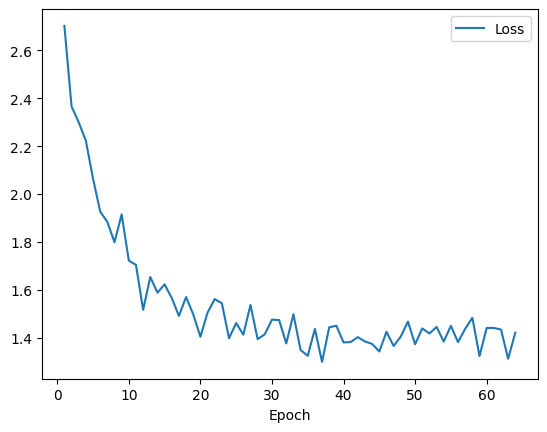

In [ ]:
df.plot(x ='Epoch', y='Loss', kind = 'line')

In [ ]:
val_acc, val_pred, val_per = net.evaluate(validation_dataset)

In [ ]:
train_acc, train_pred, train_per = net.evaluate(train_dataset)

In [ ]:
train_per

2.4366996327589905

In [ ]:
val_per

6.972607726896829

In [ ]:
def get_type(tokens):
    vec = []
    enc = enchant.Dict("en_IN")
    for w in tokens:
        if enc.check(w): 
            vec.append(1) #English
        else: 
            vec.append(0) #Hindi
    return vec

def predict(net, dataset, device, word, word_type, hidden_state_x, hidden_state_t):
    token2int = dataset.get_vocab()
    int2token = dataset.ind2vocab_h
    inputs = torch.tensor(token2int[word]).unsqueeze(0).unsqueeze(0).cuda()
    word_type = torch.tensor([[word_type]]).cuda()
    hidden_state_x = tuple([each.data for each in hidden_state_x])
    hidden_state_t = tuple([each.data for each in hidden_state_t])
    out, hidden_state_x, hidden_state_t = net(inputs, word_type, hidden_state_x, hidden_state_t)
    output = F.softmax(out, dim=1)[0].cpu().detach().numpy()
    top_n_idx = output.argsort()[::-1][:3]
    sampled_token_index = token2int['<unk>']
    while int2token[sampled_token_index]=='<unk>':
      sampled_token_index = np.random.choice(top_n_idx)

    return int2token[sampled_token_index], hidden_state_x, hidden_state_t

def generate(net, dataset, device, size, seed):
    net.cuda()
    net.eval()
    hidden_state_x = net.get_hidden(1)
    hidden_state_t = net.get_hidden(1)
    all_tokens = seed.split()
    lng = get_type(all_tokens)
    for word, typ in zip(seed.split(),lng):
        token, hidden_state_x, hidden_state_t = predict(net, dataset, device, word, typ, hidden_state_x, hidden_state_t)
    all_tokens.append(token)
    for i in range(size-1):
        token, hidden_state_x, hidden_state_t = predict(net, dataset, device, all_tokens[-1], typ, hidden_state_x, hidden_state_t)
        all_tokens.append(token)
    return ' '.join(all_tokens)

In [ ]:
generate(net,train_dataset,device,15,"life")

'life ji raha he dusre konse actors ko is movie ke baare mein hai <end> tha'

In [ ]:
def get_mix_factor(sentences):
    encs = enchant.Dict("en_IN")
    mix_factor = []
    for sentence in sentences:
        eng_words = 0
        total_words = 0
        score = 0
        words = sentence.split()
        total_words += len(words)
        for word in words:
            if encs.check(word):
                eng_words += 1
        if eng_words != total_words :
            score = eng_words/abs(total_words-eng_words) 
        if score > 1:
            score = 1/score 
        mix_factor.append(score* 100)
    return mix_factor

In [ ]:
def generate_random_sentances(net,dataset,device,count,size):
    int2token = dataset.ind2vocab_h
    sentances = []
    for i in range(count):
        random_seed = random.randrange(2, len(int2token))
        sentance = generate(net,dataset,device,size,int2token[random_seed])
        sentances.append(sentance)
    mix_factor = get_mix_factor(sentances)
    return sentances, mix_factor

In [ ]:
sentances, mix_factor = generate_random_sentances(net,train_dataset,device,100,10)

In [ ]:
sum(mix_factor)/len(mix_factor)

50.10277777777779

In [ ]:
generate(net,train_dataset,device,10,"life me always")

'life me always wonder karti hai yah use itna trouble kiya <end> ne'